In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import smogn
import h5py
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr, ks_2samp

In [3]:
c = 3.*10**8

with h5py.File(r'C:\Users\tirth\Documents\Projects\Halo - galaxy connection\Self project\data\raw\groups_090_lh_135.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
    R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
    V_h  =  f['Group/GroupVel'][:]                  #km/s
    V_h =   np.linalg.norm(V_h, axis = 1)
    ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

    # Positions, stellar masses,  of the galaxies
    SM     = f['Subhalo/SubhaloMassType'][:, 4]*1e10 #Msun/h
    SFR    = f['Subhalo/SubhaloSFR'][:]*1e10 #Msun/yr
    SR = f['Subhalo/SubhaloHalfmassRadType'][:, 4]
    Colour = f['Subhalo/SubhaloStellarPhotometrics'][:, 4] - f['Subhalo/SubhaloStellarPhotometrics'][:, 5] #g-r 
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)

indexes = np.where(SM > 0)[0]
SM = SM[indexes]
SFR = SFR[indexes]
SR = SR[indexes]
Colour = Colour[indexes]
ID_g = ID_g[indexes]

#Galaxy catalog
data = np.array([SM, SFR, Colour, SR, ID_g]).T
columns = ['SM', 'SFR', 'Colour', 'SR', 'ID']
gals = pd.DataFrame(data=data, columns=columns)

gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

gals['SFR'] = gals['SFR'].replace(0, 1)
gals['SFR'] = np.log10(gals['SFR'])
gals.loc[gals['SFR'] == 0, 'SFR'] = np.random.normal(8.0, 0.5, len(gals.loc[gals['SFR'] == 0]))
#gals.shape

#SM.shape, M_h.shape

df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')

df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])

df['SM']  = np.log10(df['SM'])
#df['SR']  = np.log10(df['SR'] + 0.01)

In [4]:
df.describe()

,M_h,R_h,V_h,ID,SM,SFR,Colour,SR
count,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000
mean,10.812412,-6.661764,2.363036,1343.859041,7.806341,8.163528,0.499229,4.406290
std,0.583957,0.194653,0.253831,1561.821005,0.914313,0.629484,0.117974,4.736099
min,9.258652,-7.179672,1.007122,0.000000,6.383125,6.400764,-0.491766,0.000000
25%,10.443458,-6.784751,2.193398,432.500000,7.113954,7.748746,0.461092,0.000000
50%,10.723163,-6.691520,2.375805,912.000000,7.518476,8.096715,0.491699,4.245553
75%,11.073852,-6.574630,2.535979,1664.000000,8.192211,8.496402,0.559661,6.857106
max,13.900575,-5.632371,2.995397,15209.000000,11.450767,10.733286,0.788267,37.242687


Text(0.5, 0, 'V_h')

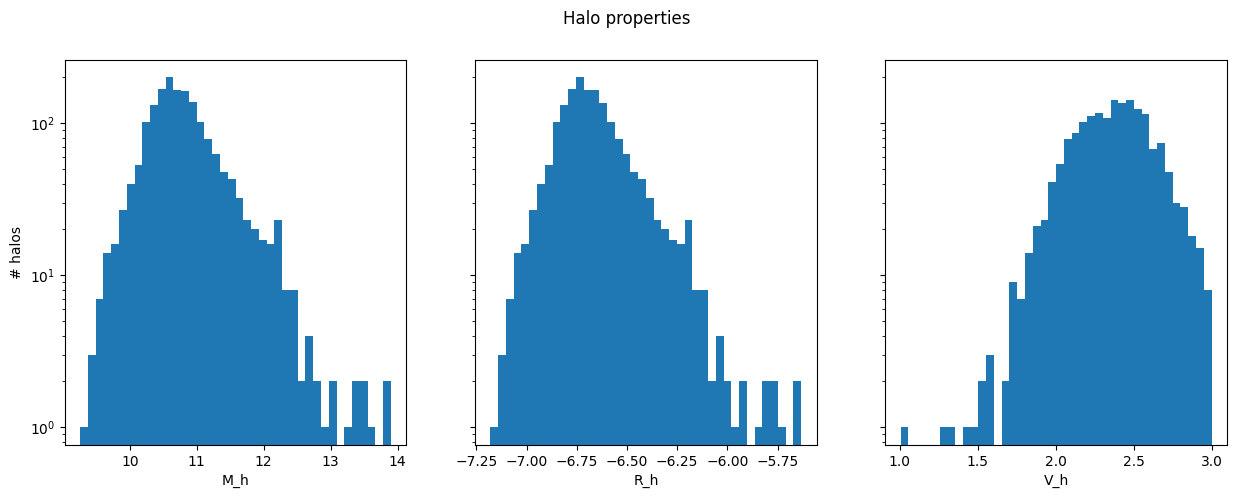

In [5]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'], bins = 40)
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'], bins = 40)
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'], bins = 40)
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

Text(0.5, 0, 'SFR')

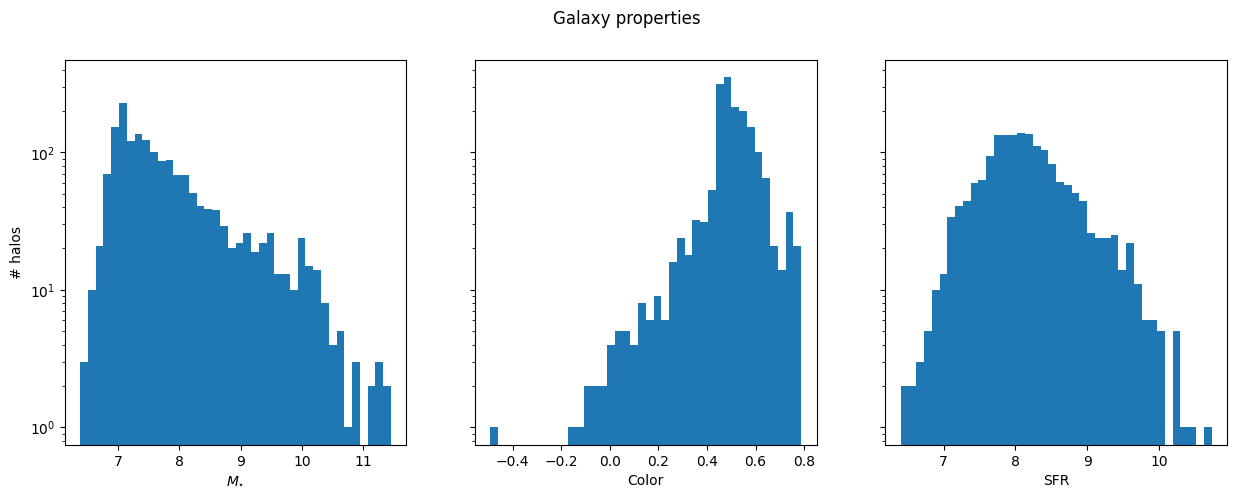

In [6]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Galaxy properties')

axs[0].hist(df['SM'], bins = 40)
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel('# halos')

axs[1].hist(df['Colour'], bins = 40)
axs[1].set_yscale('log')
axs[1].set_xlabel('Color')

axs[2].hist(df['SFR'], bins = 40)
axs[2].set_yscale('log')
axs[2].set_xlabel('SFR')

In [ ]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.4f',
                square = True, linewidths = .5, annot = True, 
                cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

correlation_heatmap(df)

In [ ]:
plt.scatter(df['M_h'], df['SM'], s=1)
plt.xlabel(r'$M_{\mathrm{halo}} \,/\, M_{\odot}$')
plt.ylabel(r'$M_{\star} \,/\, M_{\odot}$')

In [8]:
df.head()

,M_h,R_h,V_h,ID,SM,SFR,Colour,SR
0,13.653268,-5.714802,1.431432,0.0,11.630214,8.243891,0.762205,30.098984
1,13.281644,-5.838683,1.751035,1.0,11.370838,7.339507,0.762400,9.118227
2,13.303414,-5.831418,2.276157,2.0,11.220836,8.386258,0.748251,14.697025
3,13.185764,-5.870649,1.467040,3.0,11.512475,7.148647,0.802225,5.556552
4,13.200743,-5.865651,2.303855,4.0,11.332070,8.381227,0.760628,19.559307


In [9]:
halos = df[['M_h', 'R_h', 'V_h']]
gals = df[['SM', 'SFR', 'Colour', 'SR']]

halos_train, halos_test, gals_train, gals_test = train_test_split(halos, gals, test_size=0.2, random_state=42)

In [10]:
halos_scalar = StandardScaler()
gals_scalar = StandardScaler()

halos_train = halos_scalar.fit_transform(halos_train)
halos_test = halos_scalar.transform(halos_test)
gals_train = gals_scalar.fit_transform(gals_train)
gals_test = gals_scalar.transform(gals_test)

halos_train_scaled = torch.tensor(halos_train, dtype=torch.float32)
halos_test_scaled = torch.tensor(halos_test, dtype=torch.float32)
gals_train_scaled = torch.tensor(gals_train, dtype=torch.float32)
gals_test_scaled = torch.tensor(gals_test, dtype=torch.float32)

In [11]:
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [12]:
halos_dim = 3
gals_dim = 4

dist_base = dist.Normal(torch.zeros(halos_dim), torch.ones(halos_dim) * 0.2).to_event(1)
x1_transform = T.spline(halos_dim)
x3_transform = T.affine_coupling(halos_dim)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform, x3_transform]) 

x2_transform = T.conditional_spline(gals_dim, context_dim=halos_dim)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist.Normal(torch.zeros(gals_dim), 
                                            torch.ones(gals_dim) * 0.2).to_event(1), [x2_transform])

In [13]:
steps = 1301
modules = torch.nn.ModuleList([x1_transform, x3_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-2)

running_loss = 0
for step in range(steps+1):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(halos_train_scaled)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(halos_train_scaled.detach()).log_prob(gals_train_scaled.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()
    running_loss += 10**loss.item()
    
    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 167.45999145507812
step: 100, loss: 21.301294326782227
step: 200, loss: 15.950521469116211
step: 300, loss: 14.078961372375488
step: 400, loss: 15.332249641418457
step: 500, loss: 13.889490127563477
step: 600, loss: 14.127150535583496
step: 700, loss: 14.043694496154785
step: 800, loss: 14.004009246826172
step: 900, loss: 13.253273963928223
step: 1000, loss: 16.792861938476562
step: 1100, loss: 12.345771789550781
step: 1200, loss: 12.496703147888184
step: 1300, loss: 12.160226821899414


In [14]:
halos_flow = dist_x1.sample(torch.Size([int(1e3)]))

gals_flow = dist_x2_given_x1.condition(halos_flow).sample(torch.Size([int(1e3)]))

halos_flow = halos_scalar.inverse_transform(halos_flow).flatten()
gals_flow = gals_scalar.inverse_transform(gals_flow).flatten

In [ ]:
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 2])

fig, axd = plt.subplot_mosaic([['upper left', 'upper right'], 
                               ['lower left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(7, 7), 
                              constrained_layout=True)

xlims = [9, 14]
ylims = [6, 12]

# Note: halos_train and gals_train were overwritten by scaling earlier (they are numpy arrays),
# so inverse-transform them back to the original scale for plotting.
halos_train_unscaled = halos_scalar.inverse_transform(halos_train)
gals_train_unscaled  = gals_scalar.inverse_transform(gals_train)

# Resample flow outputs and convert to numpy, then inverse-transform
with torch.no_grad():
    halos_flow_t = dist_x1.sample(torch.Size([int(1e3)]))
    gals_flow_t = dist_x2_given_x1.condition(halos_flow_t).sample(torch.Size([int(1e3)]))

halos_flow_np = halos_flow_t.detach().cpu().numpy()
gals_flow_np  = gals_flow_t.detach().cpu().numpy()

halos_flow_unscaled = halos_scalar.inverse_transform(halos_flow_np)
gals_flow_unscaled  = gals_scalar.inverse_transform(gals_flow_np)

axd['upper right'].remove()

ax = axd['lower left']
ax.scatter(halos_train_unscaled[:, 0], gals_train_unscaled[:, 0], s=2, alpha=0.6, label='data', color='firebrick')
ax.scatter(halos_flow_unscaled[:, 0], gals_flow_unscaled[:, 0], s=2, alpha=0.6, label='flow', color='C0')
ax.set_xlabel(r'$\mathrm{log_{10}}(M_{\mathrm{halo}} \,/\, M_{\odot})$')
ax.set_ylabel(r'$\mathrm{log_{10}}(M_{\star} \,/\, M_{\odot})$')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.legend()

ax = axd['upper left']    
sns.kdeplot(halos_train_unscaled[:, 0], ax=ax, color='firebrick')
sns.kdeplot(halos_flow_unscaled[:, 0], ax=ax, color='C0')
ax.set_xlim(xlims)

ax = axd['lower right']    
sns.kdeplot(y=gals_train_unscaled[:, 0], ax=ax, color='firebrick')
sns.kdeplot(y=gals_flow_unscaled[:, 0], ax=ax, color='C0')
ax.set_ylim(ylims)

In [16]:
ln_p_x1_test = dist_x1.log_prob(halos_test_scaled)

ln_p_x2_given_x1_test = dist_x2_given_x1.condition(halos_test_scaled).log_prob(gals_test_scaled)

log_likelihood = (ln_p_x1_test + ln_p_x2_given_x1_test).mean()

nll = -(ln_p_x1_test + ln_p_x2_given_x1_test).mean()

print("Negative Log-Likelihood (NLL):", nll.item())

Negative Log-Likelihood (NLL): 8.628353118896484


In [ ]:
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 2])

fig, axd = plt.subplot_mosaic([['upper left', 'upper right'], 
                               ['lower left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(7, 7), 
                              constrained_layout=True)

xlims = [9, 14]
ylims = [6, 12]

# Note: halos_test and gals_test were overwritten by scaling earlier (they are numpy arrays),
# so inverse-transform them back to the original scale for plotting.
halos_test_unscaled = halos_scalar.inverse_transform(halos_test)
gals_test_unscaled  = gals_scalar.inverse_transform(gals_test)

# Resample flow outputs and convert to numpy, then inverse-transform
with torch.no_grad():
    halos_flow_t = dist_x1.sample(torch.Size([int(1e3)]))
    gals_flow_t = dist_x2_given_x1.condition(halos_flow_t).sample(torch.Size([int(1e3)]))

halos_flow_np = halos_flow_t.detach().cpu().numpy()
gals_flow_np  = gals_flow_t.detach().cpu().numpy()

halos_flow_unscaled = halos_scalar.inverse_transform(halos_flow_np)
gals_flow_unscaled  = gals_scalar.inverse_transform(gals_flow_np)

axd['upper right'].remove()

ax = axd['lower left']
ax.scatter(halos_test_unscaled[:, 0], gals_test_unscaled[:, 0], s=2, alpha=0.6, label='data', color='firebrick')
ax.scatter(halos_flow_unscaled[:, 0], gals_flow_unscaled[:, 0], s=2, alpha=0.6, label='flow', color='C0')
ax.set_xlabel(r'$\mathrm{log_{10}}(M_{\mathrm{halo}} \,/\, M_{\odot})$')
ax.set_ylabel(r'$\mathrm{log_{10}}(M_{\star} \,/\, M_{\odot})$')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.legend()

ax = axd['upper left']    
sns.kdeplot(halos_test_unscaled[:, 0], ax=ax, color='firebrick')
sns.kdeplot(halos_flow_unscaled[:, 0], ax=ax, color='C0')
ax.set_xlim(xlims)

ax = axd['lower right']    
sns.kdeplot(y=gals_test_unscaled[:, 0], ax=ax, color='firebrick')
sns.kdeplot(y=gals_flow_unscaled[:, 0], ax=ax, color='C0')
ax.set_ylim(ylims)

In [ ]:
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 2])

fig, axd = plt.subplot_mosaic([['upper left', 'upper right'], 
                               ['lower left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(7, 7), 
                              constrained_layout=True)

axd['upper right'].remove()
axd['upper left'].remove()
xlims = [9, 14]
ylims = [6, 12]

hmasses = [10, 10.5, 11, 11.5, 12, 12.5]
cmap = plt.colormaps['Spectral']  # Fixed deprecated get_cmap
means_raw = halos_scalar.mean_

for i, hmass in enumerate(hmasses):
    # Choose a color from the colormap
    color = cmap(i / len(hmasses))
    
    # Generate 1000 halo samples with fixed hmass but mean Rh and Vh
    N = int(1e3)
    template = np.tile(means_raw, (N, 1))  # Shape: (1000, 3)
    template[:, 0] = hmass  # Set the first column (M_h) to the desired hmass
    
    # Scale with the halo scaler and convert to torch
    # Convert to DataFrame with correct column names (with underscores!)
    template_df = pd.DataFrame(template, columns=['M_h', 'R_h', 'V_h'])
    halos_cond_scaled = halos_scalar.transform(template_df)
    halos_cond_t = torch.tensor(halos_cond_scaled, dtype=torch.float32)
    
    # Generate galaxies conditioned on this halo vector
    gals_flow_t = dist_x2_given_x1.condition(halos_cond_t).sample(torch.Size([N]))
    
    # Inverse-transform for plotting (use only the mass columns)
    halos_mass = halos_scalar.inverse_transform(halos_cond_t.detach().cpu().numpy())[:, 0]
    gals_mass = gals_scalar.inverse_transform(gals_flow_t.detach().cpu().numpy())[:, 0]

    # Plot the conditioned samples
    ax = axd['lower left']
    ax.scatter(halos_mass, gals_mass, s=2, alpha=0.6, label=hmass, color=color)
    # Use raw string (r'') to fix invalid escape sequence warning
    ax.set_xlabel(r'$\mathrm{log_{10}}(M_{\mathrm{halo}} \,/\, \mathrm{M_{\odot}})$')
    ax.set_ylabel(r'$\mathrm{log_{10}}(M_{\star} \,/\, \mathrm{M_{\odot}})$')
    ax.set_xlim(xlims); ax.set_ylim(ylims)
    ax.legend()

    ax = axd['lower right']
    sns.kdeplot(y=gals_mass, ax=ax, color=color)
    ax.set_ylim(ylims)

In [ ]:
from scipy.stats import ks_2samp, wasserstein_distance

# Number of posterior samples
N_posterior = 1000

# Get test set data (unscaled)
halos_test_unscaled = halos_scalar.inverse_transform(halos_test)
gals_test_unscaled = gals_scalar.inverse_transform(gals_test)

# Storage for predictions
n_test = len(halos_test)
gals_pred_mean = np.zeros((n_test, 4))  # 4 galaxy properties
gals_pred_random = np.zeros((n_test, 4))  # 4 galaxy properties

# Generate posterior for each test galaxy
print("Generating posteriors for test set...")
for i in range(n_test):
    # Get the halo properties for this test sample
    halo_i = torch.tensor(halos_test[i:i+1], dtype=torch.float32)
    
    # Generate N_posterior samples conditioned on this halo
    with torch.no_grad():
        gals_posterior_i = dist_x2_given_x1.condition(halo_i).sample(torch.Size([N_posterior]))
    
    # Inverse transform
    gals_posterior_unscaled = gals_scalar.inverse_transform(gals_posterior_i.detach().cpu().numpy())
    
    # Mean prediction
    gals_pred_mean[i] = gals_posterior_unscaled.mean(axis=0)
    
    # Random prediction
    random_idx = np.random.randint(0, N_posterior)
    gals_pred_random[i] = gals_posterior_unscaled[random_idx]

# Property names
property_names = ['Stellar Mass', 'SFR', 'Radius', 'Colour']

# Compute metrics for both methods
methods = {
    'NF (Mean)': gals_pred_mean,
    'NF (Random)': gals_pred_random
}

# Storage for metrics
metrics_data = {
    'PCC': {},
    'RMSE': {},
    'K-S Test': {},
    'Wasserstein': {}
}

for method_name, predictions in methods.items():
    pcc_vals = []
    rmse_vals = []
    ks_vals = []
    ws_vals = []
    
    for j in range(4):
        y_true = gals_test_unscaled[:, j]
        y_pred = predictions[:, j]
        
        # PCC
        pcc, _ = pearsonr(y_true, y_pred)
        pcc_vals.append(pcc)
        
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_vals.append(rmse)
        
        # K-S Test
        ks_stat, _ = ks_2samp(y_true, y_pred)
        ks_vals.append(ks_stat)
        
        # Wasserstein
        ws_dist = wasserstein_distance(y_true, y_pred)
        ws_vals.append(ws_dist)
    
    metrics_data['PCC'][method_name] = pcc_vals
    metrics_data['RMSE'][method_name] = rmse_vals
    metrics_data['K-S Test'][method_name] = ks_vals
    metrics_data['Wasserstein'][method_name] = ws_vals

# Create the comparison plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

metric_names = ['PCC', 'RMSE', 'K-S Test', 'Wasserstein']
x = np.arange(len(property_names))
width = 0.35

for idx, metric_name in enumerate(metric_names):
    ax = axes[idx]
    
    # Plot bars for each method
    offset = 0
    for i, (method_name, color) in enumerate(zip(['NF (Mean)', 'NF (Random)'], 
                                                   ['#1f77b4', '#ff7f0e'])):
        values = metrics_data[metric_name][method_name]
        ax.bar(x + offset, values, width, label=method_name, color=color, alpha=0.8)
        offset += width
    
    ax.set_xlabel('Property', fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f'{metric_name}: Normalizing Flow Methods', fontsize=13, fontweight='bold')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(property_names, rotation=0)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Also create line plots like in the reference image
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Pearson Correlation plot
ax = axes[0]
for method_name, marker, color in zip(['NF (Mean)', 'NF (Random)'], 
                                       ['o-', 's-'], 
                                       ['#1f77b4', '#ff7f0e']):
    ax.plot(property_names, metrics_data['PCC'][method_name], 
            marker, label=method_name, linewidth=2, markersize=8, color=color)

ax.set_xlabel('Property', fontsize=12)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.set_title('Pearson Correlation: Normalizing Flow Predictions', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# RMSE plot
ax = axes[1]
for method_name, marker, color in zip(['NF (Mean)', 'NF (Random)'], 
                                       ['o-', 's-'], 
                                       ['#1f77b4', '#ff7f0e']):
    ax.plot(property_names, metrics_data['RMSE'][method_name], 
            marker, label=method_name, linewidth=2, markersize=8, color=color)

ax.set_xlabel('Property', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE: Normalizing Flow Predictions', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import tarp

# Generate posterior samples for all test galaxies
n_test = len(halos_test)
N_posterior = 1000
n_properties = 4

# Storage for posterior samples: shape (N_posterior, n_test, n_properties)
posterior_samples = np.zeros((N_posterior, n_test, n_properties))

print("Generating posterior samples for TARP test...")
for i in range(n_test):
    # Get the halo properties for this test sample
    halo_i = torch.tensor(halos_test[i:i+1], dtype=torch.float32)
    
    # Generate N_posterior samples conditioned on this halo
    with torch.no_grad():
        gals_posterior_i = dist_x2_given_x1.condition(halo_i).sample(torch.Size([N_posterior]))
    
    # Inverse transform to original space
    gals_posterior_unscaled = gals_scalar.inverse_transform(gals_posterior_i.detach().cpu().numpy())
    posterior_samples[:, i, :] = gals_posterior_unscaled

# True values (theta) - shape: (n_test, n_properties)
theta_true = gals_test_unscaled

# Property names
property_names = ['SM', 'SFR', 'Colour', 'SR']

print("\n=== Step 5: TARP Test Results ===\n")

# Perform TARP test for each property individually
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for j, prop_name in enumerate(property_names):
    # Get samples for this property: shape (N_posterior, n_test, 1)
    samples_j = posterior_samples[:, :, j:j+1]
    theta_j = theta_true[:, j:j+1]
    
    # Get TARP coverage
    ecp, alpha = tarp.get_tarp_coverage(
        samples_j, 
        theta_j, 
        references='random',
        metric='euclidean',
        norm=True
    )
    
    # Plot
    ax = axes[j]
    ax.plot([0, 1], [0, 1], 'k--', label='Ideal calibration')
    ax.plot(alpha, ecp, 'b-', linewidth=2, label='TARP coverage')
    ax.fill_between(alpha, alpha - np.sqrt(alpha * (1 - alpha) / n_test), 
                     alpha + np.sqrt(alpha * (1 - alpha) / n_test), 
                     alpha=0.2, color='gray', label='Expected deviation')
    ax.set_xlabel('Credibility Level (α)')
    ax.set_ylabel('Expected Coverage Probability')
    ax.set_title(f'{prop_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Test all properties together
print("\nTARP test for all galaxy properties combined:")
ecp_all, alpha_all = tarp.get_tarp_coverage(
    posterior_samples, 
    theta_true, 
    references='random',
    metric='euclidean',
    norm=True
)

# Plot combined result
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--', label='Ideal calibration', linewidth=2)
ax.plot(alpha_all, ecp_all, 'b-', linewidth=2, label='TARP coverage (all properties)')
ax.fill_between(alpha_all, 
                 alpha_all - np.sqrt(alpha_all * (1 - alpha_all) / n_test), 
                 alpha_all + np.sqrt(alpha_all * (1 - alpha_all) / n_test), 
                 alpha=0.2, color='gray', label='Expected deviation')
ax.set_xlabel('Credibility Level (α)', fontsize=12)
ax.set_ylabel('Expected Coverage Probability', fontsize=12)
ax.set_title('TARP Test: All Galaxy Properties', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()